### **Задачи:** <br>

*   Определение зависимости между понятностью тиккера и ее годовой доходности<br>
*   Рассмотрение зависимости положения первой буквы тиккера в алфавите и ее годовой доходности



### Подгрузка библиотек и необходимых для работы данных


*   Подгрузка библиотек




In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

#from pandas_datareader import DataReader
from datetime import datetime
from datetime import date

*   Подгрузка необходимых данных 




In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys

In [4]:
sys.path.append('/content/drive/MyDrive/Fin_lab')

Список из 43 тиккеров Мосбиржи 

In [5]:
tickers = ['GAZP', 'SBER', 'SBERP', 'LKOH', 'YNDX', 'GMKN', 'NVTK', 'TCSG', 'ROSN', 'POLY', 'PLZL', 'ALRS', 'MGNT', 'TATN', 'CHMF', 'NLMK', \
           'SNGS', 'FIVE', 'MTSS', 'MOEX', 'VTBR', 'SNGSP', 'OZON', 'MAIL', 'FIXP', 'PIKK', 'IRAO', 'PHOR', 'MAGN', 'RUAL', 'HHRU', 'AFKS', \
           'TRNFP','HYDR', 'RTKM', 'DSKY', 'AFLT', 'TATNP', 'GLTR', 'POGR', 'CBOM', 'FEES', 'LSRG']

Подгрузка исторических данных акций

In [6]:
from inherited_classes.inh_getting_market_data_universal import MoscowExchangeData


#tickers = list(set_all_russian_stocks)

dict_urls = {'foreign_shares': 'https://iss.moex.com/iss/history/engines/stock/markets/foreignshares/securities/',
             'russian_shares': 'https://iss.moex.com/iss/history/engines/stock/markets/shares/boards/tqbr/securities/',
             #'russian_shares': 'http://iss.moex.com/iss/history/engines/stock/markets/shares/boards/tqbe/securities/',
            'indices': 'https://iss.moex.com/iss/history/engines/stock/markets/index/boards/SNDX/securities/'}

dict_slices = {'foreign_shares': -8,
             'russian_shares': -2,
            'indices': -2}

start_date = '2013-03-25'
finish_date = '2021-04-15'

market_data_getter = MoscowExchangeData(dict_urls, dict_slices, tickers, start_date, finish_date)
res = market_data_getter.get_data(market='russian_shares')

### Разметка

Разметка тиккеров на легкость их восприятия, <br> 
где 1 - понятный разметчику,
0 - непонятный 


In [7]:
tag = pd.DataFrame(index=tickers, columns=['tagger_1', 'tagger_2', 'tagger_3'])

In [8]:
tag['tagger_1'] = [1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1]
tag['tagger_2'] = [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0]
tag['tagger_3'] = list('1111111111011101001110111111111101001100001')
tag['tagger_3'] = tag['tagger_3'].apply(int)

In [9]:
for i in list(tag.index):
  if list(tag.loc[i]).count(1) == 3:
    tag.loc[i, 'overall'] = int(round(1, 0))
  elif list(tag.loc[i]).count(1) == 2:
    tag.loc[i, 'overall'] = int(round(1, 0))
  else:
    tag.loc[i, 'overall'] = int(round(0, 0))

In [10]:
tag = tag.astype(int)

In [11]:
tag.head()

,tagger_1,tagger_2,tagger_3,overall
GAZP,1,1,1,1
SBER,1,1,1,1
SBERP,0,1,1,1
LKOH,0,0,1,0
YNDX,1,1,1,1


Удаление тиккеров POGR, GLTR, HHRU, FIXP, так как для них недостаточно данных (на IPO менее трех лет) <br>
Анализ будет проводиться на 39 акций, размещенных на Мосбирже

In [12]:
tag.drop(['POGR', 'GLTR', 'HHRU', 'FIXP'], axis=0, inplace=True)

Создание списка с понятными тиккерами

In [13]:
comprehensible = list(tag.query('overall == 1').index)

Создание списка с непонятными тиккерами

In [14]:
 incomprehensible = list(tag.query('overall == 0').index)

Классы сбалансированны

In [15]:
list(tag['overall']).count(1) / 39

0.5897435897435898

### Определение зависимости между понятностью тиккера и ее годовой доходности

Создание датафреймв с акциями и ценами закрытия 

In [16]:
df = res['GAZP'][['TRADEDATE', 'CLOSE']]

for i in list(res.keys())[1:]:
    ticker = res[i][['TRADEDATE', 'CLOSE']]
    df = df.merge(ticker, how='outer', on='TRADEDATE')
df.columns = ['TRADEDATE'] + list(res.keys())
df['TRADEDATE'] = pd.to_datetime(df['TRADEDATE'])
df['TRADEDATE'] = sorted(df['TRADEDATE'])

In [17]:
df = df.replace('', np.nan)

In [18]:
df.drop(['POGR', 'GLTR', 'HHRU', 'FIXP'], axis=1, inplace=True)

In [19]:
df.loc[:, 'GAZP':] = df.loc[:, 'GAZP':].astype(float)

Создание таблицы с годовой доходностью акций

In [20]:
df_annual = pd.DataFrame((df.query(f"TRADEDATE == Timestamp('2013-12-30 00:00:00')").iloc[0, 1:]  - df.query(f"TRADEDATE == Timestamp('2013-03-25 00:00:00')").iloc[0, 1:]) / df.query(f"TRADEDATE == Timestamp('2013-03-25 00:00:00')").iloc[0, 1:]).T
for year in range(2014, 2021):
  if year == 2017:
      df_annual = df_annual.append(pd.DataFrame(((df.query(f"TRADEDATE == Timestamp('{year}-12-29 00:00:00')").iloc[0, 1:] - df.query(f"TRADEDATE == Timestamp('{year}-01-06 00:00:00')").iloc[0, 1:]) / df.query(f"TRADEDATE == Timestamp('{year}-01-06 00:00:00')").iloc[0, 1:])).T)
  elif year == 2018:
      df_annual = df_annual.append(pd.DataFrame(((df.query(f"TRADEDATE == Timestamp('{year}-12-29 00:00:00')").iloc[0, 1:] - df.query(f"TRADEDATE == Timestamp('{year}-01-03 00:00:00')").iloc[0, 1:]) / df.query(f"TRADEDATE == Timestamp('{year}-01-03 00:00:00')").iloc[0, 1:])).T)
  elif year == 2019:
      df_annual = df_annual.append(pd.DataFrame(((df.query(f"TRADEDATE == Timestamp('{year}-12-30 00:00:00')").iloc[0, 1:] - df.query(f"TRADEDATE == Timestamp('{year}-01-03 00:00:00')").iloc[0, 1:]) / df.query(f"TRADEDATE == Timestamp('{year}-01-03 00:00:00')").iloc[0, 1:])).T)
  else:
      df_annual = df_annual.append(pd.DataFrame(((df.query(f"TRADEDATE == Timestamp('{year}-12-30 00:00:00')").iloc[0, 1:] - df.query(f"TRADEDATE == Timestamp('{year}-01-06 00:00:00')").iloc[0, 1:]) / df.query(f"TRADEDATE == Timestamp('{year}-01-06 00:00:00')").iloc[0, 1:])).T)

df_annual.index = [x for x in range(2013, 2021)]

In [21]:
df_annual.head()

,GAZP,SBER,SBERP,LKOH,YNDX,GMKN,NVTK,TCSG,ROSN,POLY,PLZL,ALRS,MGNT,TATN,CHMF,NLMK,SNGS,FIVE,MTSS,MOEX,VTBR,SNGSP,OZON,MAIL,PIKK,IRAO,PHOR,MAGN,RUAL,AFKS,TRNFP,HYDR,RTKM,DSKY,AFLT,TATNP,CBOM,FEES,LSRG
2013,-0.0677978,-0.268759,-0.371935,0.323407,-0.25433,0.48243,0.0711206,NaN,-0.00170577,0.535945,0.970289,0.835784,0.178903,0.360593,1.27487,0.530757,0.284055,NaN,-0.197614,0.00487359,0.304587,0.549854,NaN,NaN,1.22197,90.6152,0.72405,1.10505,NaN,-0.626755,0.640883,-0.282778,-0.133311,NaN,-0.422162,0.316635,NaN,0.0546247,0.0808634
2014,0.0929639,0.708384,0.746007,0.0276045,0.180139,-0.0909971,0.426409,NaN,0.282787,0.473739,2.81145,-0.0588079,0.0423227,0.283274,0.0278072,0.0529087,0.0852281,NaN,-0.0357724,0.51087,0.195238,0.0193639,NaN,NaN,0.282564,0.911129,0.4235,0.507143,NaN,0.0331557,0.444043,0.317869,0.137141,NaN,1.14749,0.224924,NaN,0.174089,-0.0398293
2015,-0.122945,0.451421,0.539339,0.151628,0.347379,-0.0201299,0.186689,NaN,0.0153622,0.0465116,0.147028,0.285112,-0.126126,0.0364576,0.18227,0.340346,-0.269692,NaN,0.144798,0.0796248,-0.110659,-0.277898,NaN,NaN,0.159352,1.31285,-0.169877,0.619154,0.220126,0.276149,-0.0244565,0.378238,-0.209953,NaN,1.18536,0.0395337,0.129412,1.29187,0.363232
2016,0.0820572,0.564609,0.669114,0.230248,0.850496,0.197826,0.0195286,NaN,0,-0.174412,0.0763603,-0.00994709,-0.487153,0.67535,0.0606569,0.296021,-0.0202327,NaN,0.120705,0.0447631,-0.200599,-0.0886303,NaN,NaN,0.114336,-0.0734745,-0.00167434,0.179067,0.216354,-0.458636,-0.0946292,-0.194716,-0.122436,0.217089,0.00220126,0.910299,0.10907,-0.058761,-0.0761283
2017,0.0752113,-0.222672,-0.190204,0.447413,-0.0344163,0.268594,0.413867,NaN,0.266455,0.259459,0.229593,0.0231467,-0.210027,0.183472,0.14263,0.120102,-0.16358,-0.129978,-0.122504,-0.231092,-0.320289,0.324532,NaN,NaN,0.105528,0.0309278,0.098635,0.00713171,-0.0885261,-0.170526,-0.0726761,-0.317439,0.0783383,-0.088866,-0.370635,0.308526,0.237295,-0.0564103,-0.23948


Правки по значениям акция MAIL и OZON в 2019 г. 

In [22]:
df_annual.at[2019, 'MAIL'] = list((df.query(f"TRADEDATE == Timestamp('2019-12-30 00:00:00')")['MAIL'] -  df.loc[1525, 'MAIL']) / df.loc[1525, 'MAIL'])[0]
df_annual.at[2019, 'OZON'] = list((df.query(f"TRADEDATE == Timestamp('2019-12-30 00:00:00')")['OZON'] - df.loc[1627, 'OZON']) / df.loc[1627, 'OZON'])[0]


Распределение годовой доходности акций <br>
В среднем доходность акций варьировалась от -0.1 до 0.2

Удаление анномалии в 2013 году (акции ПАО «Интер РАО» выросли в 90 раз)

In [23]:
assets_2013_no_IRAO = [x for x in list(df_annual.loc[2013]) if x != 90.61523728452862]

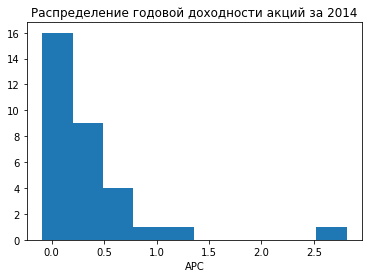

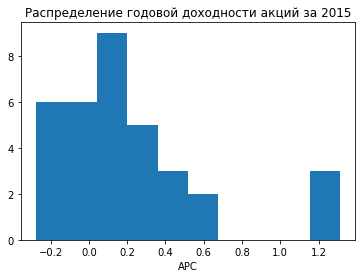

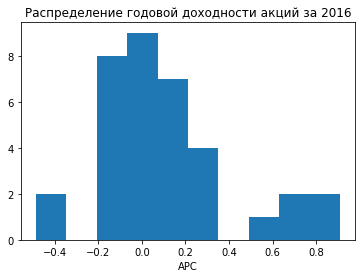

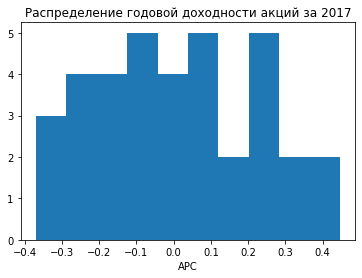

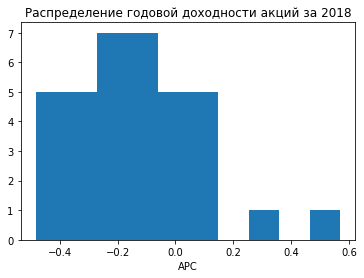

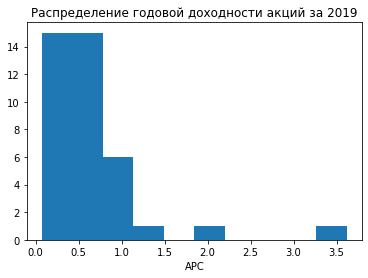

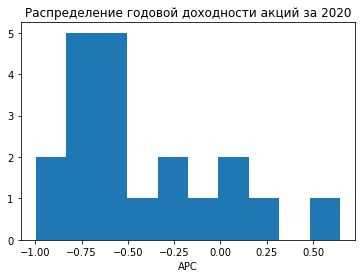

In [49]:
for year in range(2014, 2021):
    
    plt.hist(list(df_annual.loc[year]))
    plt.xlabel('APC', size=10)
    plt.title(f'Распределение годовой доходности акций за {year}')
    plt.show()


**Изучение годовой доходности понятных и непонятных акций** 

*   Изучение годовой доходности понятных акций





In [25]:
all_years_compr = []
for year in range(2013, 2021):
  if year == 2013:
    its = np.nanmean(list(df_annual[comprehensible].drop('IRAO', axis=1).loc[year]))
    print(str(year) + ': ' + str(round(its, 2)))
    all_years_compr.append(its)
  else:
    its = np.nanmean(list(df_annual[comprehensible].loc[year]))
    all_years_compr.append(its)
    print(str(year) + ': ' + str(round(its, 2)))

2013: 0.19
2014: 0.32
2015: 0.29
2016: 0.13
2017: -0.02
2018: -0.12
2019: 0.58
2020: -0.47


*   Изучение годовой доходности непонятных акций

In [26]:
all_years_incompr = []
for year in range(2013, 2021):
  its = np.nanmean(list(df_annual[incomprehensible].loc[year]))
  all_years_incompr.append(round(its, 2))
  print(str(year) + ': ' + str(round(its, 2)))

2013: 0.38
2014: 0.41
2015: 0.13
2016: 0.07
2017: 0.07
2018: -0.15
2019: 0.76
2020: -0.37


Визуализация годовой доходности акций 

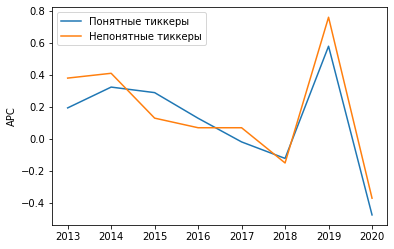

In [27]:
plt.plot([x for x in range(2013, 2021)] ,all_years_compr)
plt.plot([x for x in range(2013, 2021)] ,all_years_incompr)

plt.legend(['Понятные тиккеры', 'Непонятные тиккеры'])
plt.ylabel('APC')
plt.show()

Расчет статистической значимости для определения различия структур <br>(понятных и непонятных акций)<br>
**Нулевая гипотеза** - структуры не имеют значительных различий



In [28]:
from scipy.stats import ttest_ind

In [29]:
print('P-VALUE')
for year in range(2013, 2021):
  print(year, 'p-value:', round(ttest_ind(list(df_annual.loc[year, comprehensible]), list(df_annual.loc[year, incomprehensible]), equal_var=False, nan_policy='omit')[1], 2))

P-VALUE
2013 p-value: 0.35
2014 p-value: 0.75
2015 p-value: 0.24
2016 p-value: 0.54
2017 p-value: 0.27
2018 p-value: 0.76
2019 p-value: 0.44
2020 p-value: 0.6


Значения **p-value** за рассматриваемые года > 0.05 <br>
Нулевая гипотеза не может быть отвергнута

### Рассмотрение зависимости положения первой буквы тиккера в алфавите и ее годовой доходности

Для определения корреляции используется коэффициент Спирмена и Кендалла

Ранжирование: <br> 

1.   Акций по алфавиту 
2.   Акций по годовой доходности


In [30]:
def corr_rang(year, type='kendall'):
  tags_sorted = list(tag.index.sort_values())
  sorted_stocks = pd.DataFrame(index=tags_sorted, columns=['Rangs'])
  sorted_stocks['Rangs_letters'] = [x for x in range(1, 40)]
  df_rang = df_annual.T[[year]].sort_values(by=int(year), ascending=False)
  df_rang['Rangs_profit'] = [x for x in range(1, 40)]
  rangs_let_profit = sorted_stocks[['Rangs_letters']].join(df_rang['Rangs_profit'])
  if type == 'spearman':
    return round(rangs_let_profit.corr(method='spearman').iloc[1,0], 2)
  else:
    return round(rangs_let_profit.corr(method='kendall').iloc[1,0], 2)

Корреляция по годам 


*   Корреляция Кендалла



In [31]:
for year in range(2013, 2021):
  print(str(year) + ' correlation: ' + str(corr_rang(year)))

2013 correlation: -0.07
2014 correlation: -0.17
2015 correlation: 0.17
2016 correlation: -0.1
2017 correlation: -0.04
2018 correlation: 0.05
2019 correlation: 0.03
2020 correlation: -0.16


*   Корреляция Спирмена

In [32]:
for year in range(2013, 2021):
  print(str(year) + ' correlation: ' + str(corr_rang(year, 'spearman')))

2013 correlation: -0.12
2014 correlation: -0.26
2015 correlation: 0.24
2016 correlation: -0.13
2017 correlation: -0.04
2018 correlation: 0.08
2019 correlation: 0.04
2020 correlation: -0.22


Корреляция, как Кендалла, так и Спирмена невелика <br>
Не можем говорить о зависимости положения первой буквы тиккеры в алфавите и ее годовой доходности


### **Выводы:** <br>
*   Зависимость между понятностью тиккера и его годовой доходностью не была выявлена
*   Зависимость между расположением первой буквы тиккера в алфавите и его годовой доходностью не была выявлена
